# 4 - Face Recognition
### Imports

In [19]:
# basic
import os
import cv2
import cvlib as cv
import numpy as np
import matplotlib.pyplot as plt

# SkLearn
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, accuracy_score
from skimage.feature import hog, local_binary_pattern
from sklearn.decomposition import PCA

# constants
num_components=100     # TODO choose the appropriate number for K

### File Load

Training Images


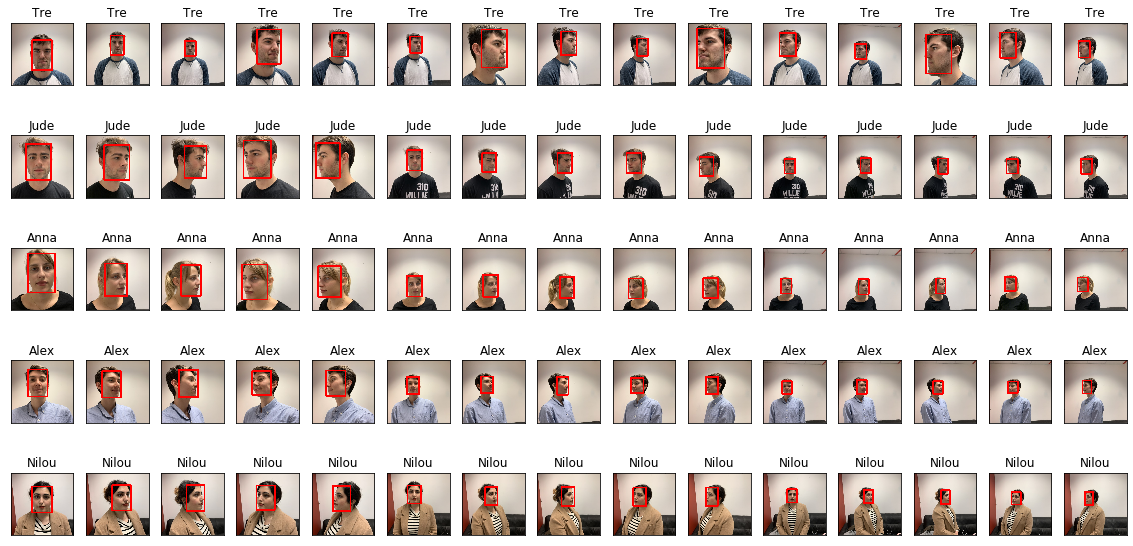

Test Images


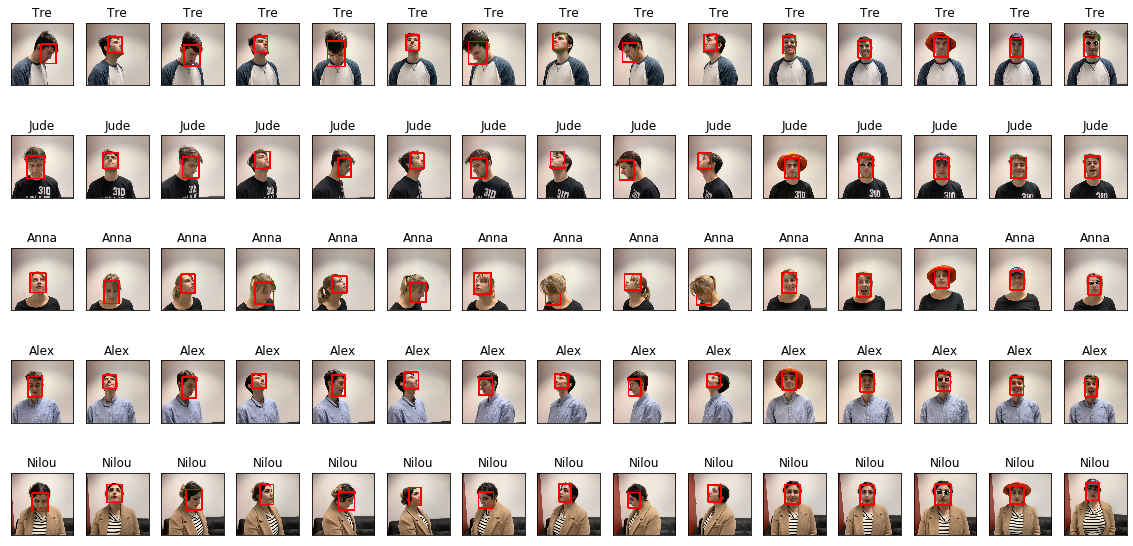

In [2]:
trainDir = "photos/preprocessed/train/"
trainHeadshots = np.empty((75, 256, 256, 3), dtype=np.uint8)
# trainBoundingBoxes = np.uint8(np.loadtxt(trainDir + "faceBoxes.txt"))
trainBoundingBoxes = np.empty((75, 4), dtype=np.uint8)
labels = np.repeat(np.array([0, 1, 2, 3, 4]), 15)
names = ["Tre", "Jude", "Anna", "Alex", "Nilou"]

print("Training Images")
plt.figure(figsize=(20, 10))
for index, filename in enumerate(os.listdir(trainDir)):
    # load images and convert to RGB
    trainHeadshots[index] = np.uint8(cv2.cvtColor(cv2.imread(os.path.join(trainDir, filename)), cv2.COLOR_BGR2RGB))

    # find bounding box of face
    face, confidence = cv.detect_face(trainHeadshots[index])
    trainBoundingBoxes[index] = [face[0][0], face[0][1], face[0][2], face[0][3]]

    # copy bounding box onto image for visual verification
    headshot_display = trainHeadshots[index].copy()
    cv2.rectangle(headshot_display, (trainBoundingBoxes[index][0], trainBoundingBoxes[index][1]), (trainBoundingBoxes[index][2], trainBoundingBoxes[index][3]), (255), thickness=5)
    plt.subplot(5, 15, index + 1)
    plt.title(names[labels[index]])
    plt.xticks([]), plt.yticks([])
    plt.imshow(headshot_display)
plt.show()


testDir = "photos/preprocessed/test/"
testHeadshots = np.empty((75, 256, 256, 3), dtype=np.uint8)
# testBoundingBoxes = np.uint8(np.loadtxt(testDir + "faceBoxes.txt"))
testBoundingBoxes = np.empty((75, 4), dtype=np.uint8)

print("Test Images")
plt.figure(figsize=(20, 10))
for index in range(75):
    # load images and convert to RGB
    testHeadshots[index] = np.uint8(cv2.cvtColor(cv2.imread(os.path.join(testDir, 'img' + str(index) + '.jpg')), cv2.COLOR_BGR2RGB))
    
    # find bounding box of face
    face, confidence = cv.detect_face(testHeadshots[index])
    if len(face) > 0:
        testBoundingBoxes[index] = [face[0][0], face[0][1], face[0][2], face[0][3]]
    else:
        # manual entry for the test image where Anna's hair obscures her face
        testBoundingBoxes[index] = [34, 189, 95, 235]

    # copy bounding box onto image for visual inspection
    headshot_display = testHeadshots[index].copy()
    cv2.rectangle(headshot_display, (testBoundingBoxes[index][0], testBoundingBoxes[index][1]), (testBoundingBoxes[index][2], testBoundingBoxes[index][3]), (255), thickness=5)

    plt.subplot(5, 15, index + 1)
    plt.title(names[labels[index]])
    plt.xticks([]), plt.yticks([])
    plt.imshow(headshot_display)
plt.show()

## 4.1 - Training: Building Vocabulary

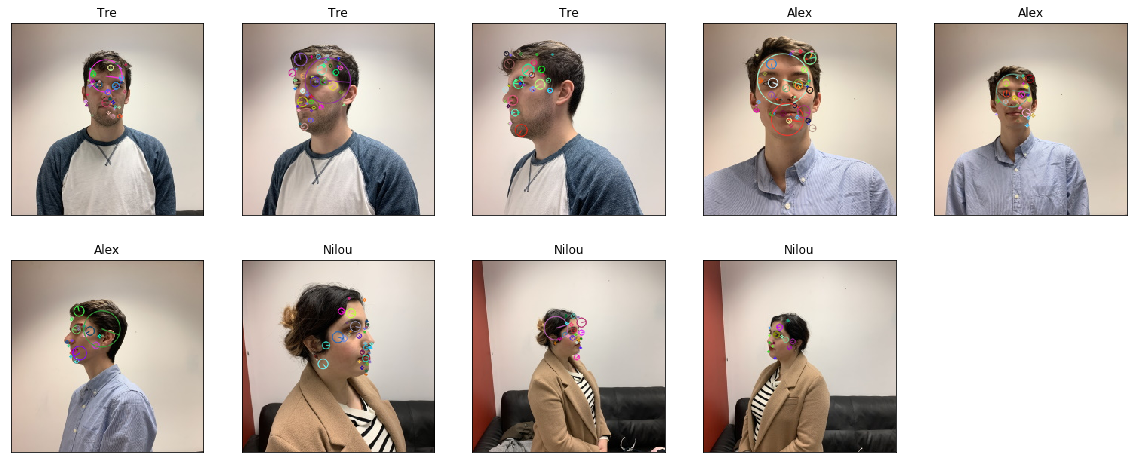

In [3]:
# create SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# holder variables for keypoints, descriptors
trainKeypoints =  []
trainDescriptors = []

# randomly select 10 images to display
dispImages = np.random.randint(0, labels.shape[0], 10)

displayedImages = 1
plt.figure(figsize=(20, 8))
for index, (headshot, boundingBox, label) in enumerate(zip(trainHeadshots, trainBoundingBoxes, labels)):
    mask = np.zeros(headshot.shape[:2], dtype=np.uint8)
    cv2.rectangle(mask, (boundingBox[0], boundingBox[1]), (boundingBox[2], boundingBox[3]), (255), thickness=-1)
    keypoints, descriptors = sift.detectAndCompute(headshot, mask)
    
    # save
    trainKeypoints.append(keypoints)
    trainDescriptors.append(descriptors)

    if index in dispImages:
        headshot_display = headshot.copy()
        cv2.drawKeypoints(headshot, keypoints, headshot_display, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.subplot(2, 5, displayedImages), plt.imshow(headshot_display), plt.title(names[label])
        plt.xticks([]), plt.yticks([])
        displayedImages += 1
plt.show()

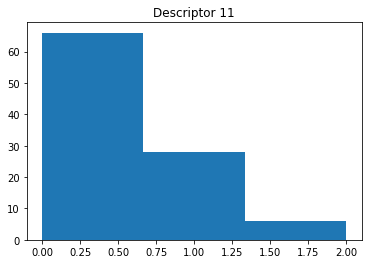

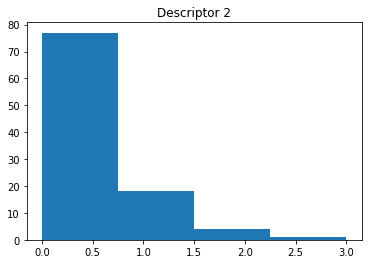

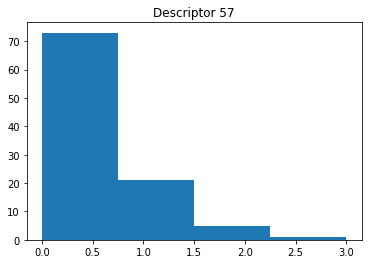

In [4]:
# descriptors = list of feature descriptors
# emModel = pre-trained GMM model
def buildHistograms(descriptors, emModel):
    histograms = []
    for descriptor in descriptors:
        histogram = np.zeros(len(em.means_))
        for i in emModel.predict(descriptor):
            histogram[i] += 1.0
        histograms.append(histogram)
    return histograms

# cluster descriptors into K clusters using the Gaussian Mixture model
em = GaussianMixture(n_components=num_components)
em = em.fit(np.concatenate(trainDescriptors))

trainHistograms = buildHistograms(trainDescriptors, em)

for i in np.random.randint(0, len(trainHistograms), 3):
    plt.hist(trainHistograms[i], bins=int(np.max(trainHistograms[i]) + 1)) # bins=num_components)
    plt.title("Descriptor {}".format(i))
    plt.show()
    
# TODO make histograms prettier?

## 4.2 - Testing: Face Recognition

In [5]:
# create SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# holder variables for keypoints, descriptors, and labels
testKeypoints =  []
testDescriptors = []

for index, (headshot, boundingBox) in enumerate(zip(testHeadshots, testBoundingBoxes)):
    mask = np.zeros(headshot.shape[:2], dtype=np.uint8)
    cv2.rectangle(mask, (boundingBox[0], boundingBox[1]), (boundingBox[2], boundingBox[3]), (255), thickness=-1)
    keypoints, descriptors = sift.detectAndCompute(headshot, mask)
    
    # save
    testKeypoints.append(keypoints)
    testDescriptors.append(descriptors)

testHistograms = buildHistograms(testDescriptors, em)

In [6]:
# trnHistList = the list of histograms of your training set (used to fit the nearest neighbour classifier)
# tstHistList = the list of histograms of your test set (the histograms you'd like to classify)
# numNeighbours = number of nearest neighbours you'd like to consider when determining the label
def findNearestNeighbour(trnHistList, tstHistList, numNeighbours=1):
    predictedLabels = []

    nn = NearestNeighbors(n_neighbors=numNeighbours)
    nn.fit(trnHistList)

    for histogram in tstHistList:
        dist, result = nn.kneighbors([histogram])
        predictedLabels.append(labels[result[0][0]])
    
    return predictedLabels

## 4.2.1 - Evaluation

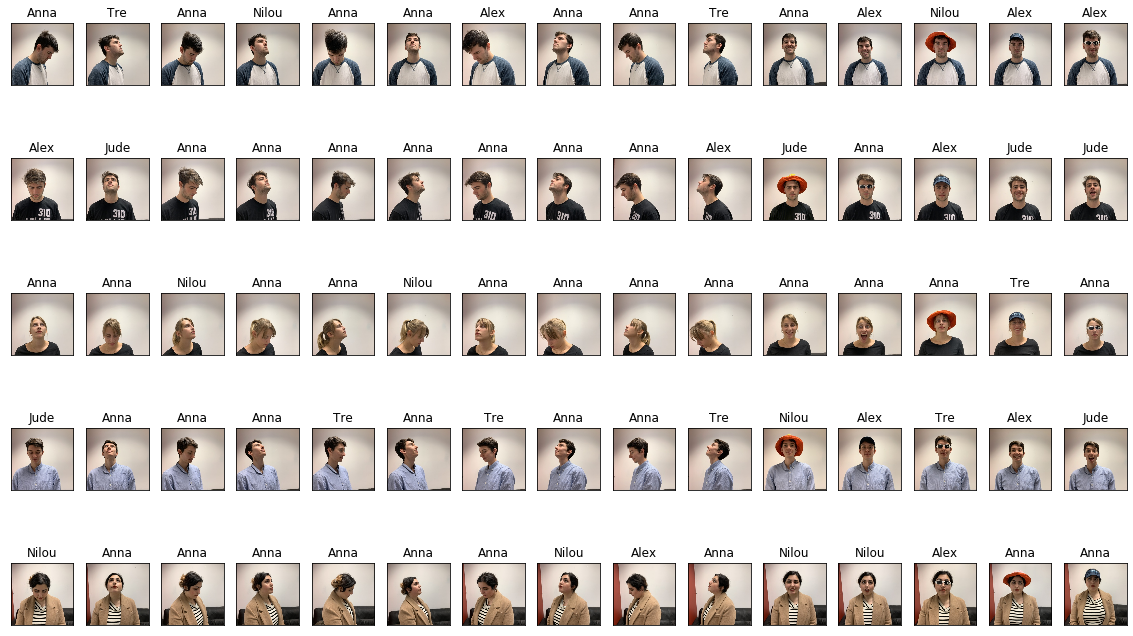

Recognition Rate: 0.32


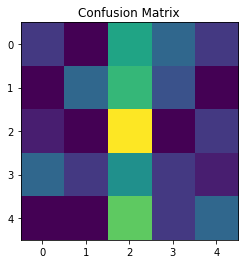

In [7]:
nearestHistogramLabels = findNearestNeighbour(trainHistograms, testHistograms)

plt.figure(figsize=(20,12))
for index, (headshot, histLabel) in enumerate(zip(testHeadshots, nearestHistogramLabels)):
    plt.subplot(5, 15, index + 1)
    plt.title(names[histLabel])
    plt.xticks([]), plt.yticks([])
    plt.imshow(headshot)
plt.show()

print('Recognition Rate: {}'.format(accuracy_score(labels, nearestHistogramLabels)))
plt.imshow(confusion_matrix(labels, nearestHistogramLabels)), plt.title('Confusion Matrix')
plt.show()

## Data Export

In [8]:
# dimensions: 75 pictures x number of keypoints x 2 points (x, y)
trainKeypointXY = np.asarray([np.asarray([point.pt for point in face]) for face in trainKeypoints])
testKeypointXY = np.asarray([np.asarray([point.pt for point in face]) for face in testKeypoints])

np.save('trainKeypointXY', trainKeypointXY)
np.save('testKeypointXY', testKeypointXY)

# 4.3 - Experiments
## 4.3.1 - Experiment 1: HoG and LBP Cell Size Variation
### HoG and LBP Descriptor Extraction

In [9]:
oBins = 9
blockSize = (2, 2)

cellSizes = [3, 4, 5]
trnHoGFeatures = ([], [], [])
tstHoGFeatures = ([], [], [])

radii = [2, 5, 7]
trnLBPFeatures = ([], [], [])
tstLBPFeatures = ([], [], [])

for trnface, tstface, trnhead, tsthead in zip(trainKeypoints, testKeypoints, trainHeadshots, testHeadshots):
    trnHoGforHeadshot = ([], [], [])
    trnLBPforHeadshot = ([], [], [])
    for point in trnface:
        # extract 15x15 window around keypoint
        window = trnhead[int(point.pt[0]) - 7 : int(point.pt[0]) + 7 + 1, int(point.pt[1]) - 7 : int(point.pt[1]) + 7 + 1, :]
        window_grey = cv2.cvtColor(window, cv2.COLOR_RGB2GRAY)
        
        # perform HoG / LBP on the window
        for index, (cellSize, radius) in enumerate(zip(cellSizes, radii)):
            trnHoGforHeadshot[index].append(np.asarray(hog(window, orientations=oBins, pixels_per_cell=(cellSize, cellSize), cells_per_block=blockSize)))
            trnLBPforHeadshot[index].append(np.asarray(local_binary_pattern(window_grey, 8 * radius, radius).flatten()))
    for i in range(3):
        trnHoGFeatures[i].append(np.asarray(trnHoGforHeadshot[i]))
        trnLBPFeatures[i].append(np.asarray(trnLBPforHeadshot[i]))
    
    tstHoGforHeadshot = ([], [], [])
    tstLBPforHeadshot = ([], [], [])
    for point in tstface:
        # extract 15x15 window around keypoint
        window = tsthead[int(point.pt[0]) - 7 : int(point.pt[0]) + 7 + 1, int(point.pt[1]) - 7 : int(point.pt[1]) + 7 + 1][:]
        window_grey = cv2.cvtColor(window, cv2.COLOR_RGB2GRAY)
        
        # perform HoG / LBP on the window
        for index, (cellSize, radius) in enumerate(zip(cellSizes, radii)):
            tstHoGforHeadshot[index].append(np.asarray(hog(window, orientations=oBins, pixels_per_cell=(cellSize, cellSize), cells_per_block=blockSize)))
            tstLBPforHeadshot[index].append(np.asarray(local_binary_pattern(window_grey, 8 * radius, radius).flatten()))
    for i in range(3):
        tstHoGFeatures[i].append(np.asarray(tstHoGforHeadshot[i]))
        tstLBPFeatures[i].append(np.asarray(tstLBPforHeadshot[i]))

# dimensions: [cellSize][image][keypoint][HoG]
trnHoGFeatures = np.asarray(trnHoGFeatures)
tstHoGFeatures = np.asarray(tstHoGFeatures)

# dimensions: [radius][image][keypoint][LBP d1][LBP d2]
trnLBPFeatures = np.asarray(trnLBPFeatures)
tstLBPFeatures = np.asarray(tstLBPFeatures)

### Evaluation of HoG and LBP Vocabularies

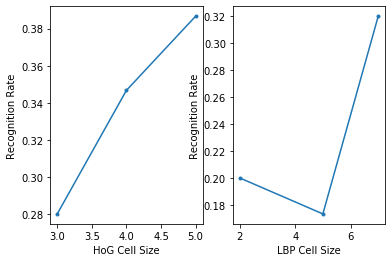

The best performing HoG cell size is 5 with a recognition rate of 0.38666666666666666.
The best performing LBP radius is 7 with a recognition rate of 0.32.


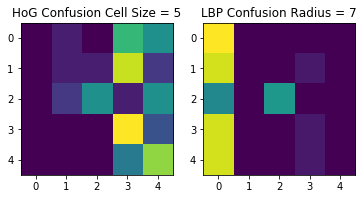

In [10]:
recognitionRatesHoG = np.zeros(3)
predictedLabelsHoG = np.empty((3, 75))
recognitionRatesLBP = np.zeros(3)
predictedLabelsLBP = np.empty((3, 75))

for i in range(3):
    # cluster HoG descriptors into K clusters using the Gaussian Mixture model
    emHoG = GaussianMixture(n_components=num_components)
    emHoG = emHoG.fit(np.concatenate(trnHoGFeatures[i]))
    
    # create HoG descriptor histograms
    trnHoGHistograms = buildHistograms(trnHoGFeatures[i], emHoG)
    tstHoGHistograms = buildHistograms(tstHoGFeatures[i], emHoG)
    
    # create label predictions and calculate recognition rate
    predictedLabelsHoG[i] = findNearestNeighbour(trnHoGHistograms, tstHoGHistograms)
    recognitionRatesHoG[i] = accuracy_score(labels, predictedLabelsHoG[i])
    
    # cluster LBP descriptors into K clusters using the Gaussian Mixture model
    emLBP = GaussianMixture(n_components=num_components, reg_covar=1e4)     # reduce reg_covar as low as possible while still functioning
    emLBP = emLBP.fit(np.concatenate(trnLBPFeatures[i]))
    
    # create LBP descriptor histograms
    trnLBPHistograms = buildHistograms(trnLBPFeatures[i], emLBP)
    tstLBPHistograms = buildHistograms(tstLBPFeatures[i], emLBP)
    
    # create label predictions and calculate recognition rate
    predictedLabelsLBP[i] = findNearestNeighbour(trnLBPHistograms, tstLBPHistograms)
    recognitionRatesLBP[i] = accuracy_score(labels, predictedLabelsLBP[i])
    
plt.subplot(1, 2, 1)
plt.plot(cellSizes, recognitionRatesHoG, marker="."), plt.xlabel("HoG Cell Size"), plt.ylabel("Recognition Rate")
plt.subplot(1, 2, 2)
plt.plot(radii, recognitionRatesLBP, marker="."), plt.xlabel("LBP Cell Size"), plt.ylabel("Recognition Rate")
plt.show()

bestPerformerHoG = np.argmax(recognitionRatesHoG)
bestPerformerLBP = np.argmax(recognitionRatesLBP)

print('The best performing HoG cell size is {} with a recognition rate of {}.'.format(cellSizes[bestPerformerHoG], recognitionRatesHoG[bestPerformerHoG]))
print('The best performing LBP radius is {} with a recognition rate of {}.'.format(radii[bestPerformerLBP], recognitionRatesLBP[bestPerformerLBP]))

plt.subplot(1, 2, 1), plt.imshow(confusion_matrix(labels, predictedLabelsHoG[bestPerformerHoG]))
plt.title('HoG Confusion Cell Size = {}'.format(cellSizes[bestPerformerHoG]))
plt.subplot(1, 2, 2), plt.imshow(confusion_matrix(labels, predictedLabelsLBP[bestPerformerLBP]))
plt.title('LBP Confusion Radius = {}'.format(radii[bestPerformerLBP]))
plt.show()

### Comparison of HoG and LBP Performance
The HoG vocabulary performs best when the cell size is set at 4, while the LBP vocabulary performs best when its radius is set to 7. The HoG vocabulary's best performance is better than the LBP vocabulary's best performance, so HoG with a cell size of 4 will be used moving forward.

TODO explain why this result happened.

TODO consider whether the massive regularization on the LBP GMM might be decreasing its performance.

## 4.3.2 - Experiment #2: Patch Size Variation

Patch size 5 is too small.


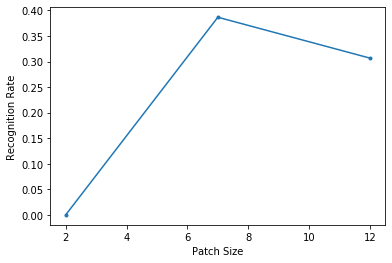

The best performing patch size is 15 with a recognition rate of 0.38666666666666666.


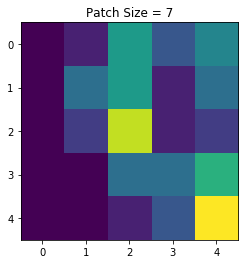

In [11]:
oBins = 9
blockSize = (2, 2)
bestCellSize = 4
patchSizes = [2, 7, 12]

trnHoGPatches = ([], [], [])
tstHoGPatches = ([], [], [])

for trnface, tstface, trnhead, tsthead in zip(trainKeypoints, testKeypoints, trainHeadshots, testHeadshots):
    trnHoGforHeadshot = ([], [], [])
    for point in trnface:       
        for index, ps in enumerate(patchSizes):
            # extract window around keypoint
            window = trnhead[int(point.pt[0]) - ps : int(point.pt[0]) + ps + 1, int(point.pt[1]) - ps : int(point.pt[1]) + ps + 1, :]
        
            # perform HoG on the window
            trnHoGforHeadshot[index].append(np.asarray(hog(window, orientations=oBins, pixels_per_cell=(cellSize, cellSize), cells_per_block=blockSize)))
    for i in range(3):
        trnHoGPatches[i].append(np.asarray(trnHoGforHeadshot[i]))
    
    tstHoGforHeadshot = ([], [], [])
    for point in tstface:        
        for index, ps in enumerate(patchSizes):
            # extract window around keypoint
            window = tsthead[int(point.pt[0]) - ps : int(point.pt[0]) + ps + 1, int(point.pt[1]) - ps : int(point.pt[1]) + ps + 1][:]
        
            # perform HoG on the window
            tstHoGforHeadshot[index].append(np.asarray(hog(window, orientations=oBins, pixels_per_cell=(cellSize, cellSize), cells_per_block=blockSize)))
    for i in range(3):
        tstHoGPatches[i].append(np.asarray(tstHoGforHeadshot[i]))      

trnHoGPatches = np.asarray(trnHoGPatches)
tstHoGPatches = np.asarray(tstHoGPatches)

recognitionRatesBestPatches = np.zeros(3)
predictedLabelsBestPatches = np.empty((3, 75))

for i in range(3):
    if (trnHoGPatches[i][0].shape[1] > 0):
        # cluster HoG descriptors into K clusters using the Gaussian Mixture model
        emBestPatches = GaussianMixture(n_components=num_components)
        emBestPatches = emBestPatches.fit(np.concatenate(trnHoGPatches[i]))

        # create HoG descriptor histograms
        trnBestPatchesHistograms = buildHistograms(trnHoGPatches[i], emBestPatches)
        tstBestPatchesHistograms = buildHistograms(tstHoGPatches[i], emBestPatches)

        # create label predictions and calculate recognition rate
        predictedLabelsBestPatches[i] = findNearestNeighbour(trnBestPatchesHistograms, tstBestPatchesHistograms)
        recognitionRatesBestPatches[i] = accuracy_score(labels, predictedLabelsBestPatches[i])
    else:
        # patch size didn't work
        print("Patch size {} is too small.".format(patchSizes[i] * 2 + 1))
        predictedLabelsBestPatches[i] = np.zeros(75)
        recognitionRatesBestPatches[i] = 0

plt.plot(patchSizes, recognitionRatesBestPatches, marker="."), plt.xlabel("Patch Size"), plt.ylabel("Recognition Rate")
plt.show()

bestPerformerPatches = np.argmax(recognitionRatesBestPatches)

print('The best performing patch size is {} with a recognition rate of {}.'.format(patchSizes[bestPerformerPatches] * 2 + 1, recognitionRatesBestPatches[bestPerformerPatches]))

plt.imshow(confusion_matrix(labels, predictedLabelsBestPatches[bestPerformerPatches]))
plt.title('Patch Size = {}'.format(patchSizes[bestPerformerPatches]))
plt.show()

TODO explain why this patch size result in the best performance.

## 4.3.3 - Experiment #3: Harris Corner Feature Extraction

The recognition rate using Harris corner feature extraction is 0.21333333333333335.


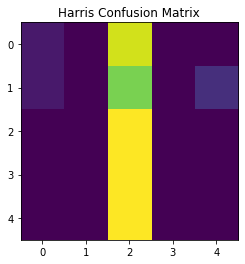

In [12]:
# Harris parameters (TODO fine-tune to optimize performance)
harrisBlock = 2
harrisKernel = 3
harrisK = 0.04
harrisThreshold = 0.01

# holder variables for (x, y) locations of keypoints
trainKeypointsHarris =  []
testKeypointsHarris = []

for index, (trnHead, trnBound, tstHead, tstBound) in enumerate(zip(trainHeadshots, trainBoundingBoxes, testHeadshots, testBoundingBoxes)):
    trnFaceWindow = np.float32(cv2.cvtColor(trnHead[trnBound[1] : trnBound[3], trnBound[0] : trnBound[2], :], cv2.COLOR_RGB2GRAY))
    keypoints = cv2.cornerHarris(trnFaceWindow, harrisBlock, harrisKernel, harrisK)
    # TODO add normalization + make the thresholding process better (see Tutorial 4)
    trnFaceWindow[keypoints > harrisThreshold * keypoints.max()] = -1
    coordinates = []
    # TODO make this more efficient
    for x in range(trnFaceWindow.shape[0]):
        for y in range(trnFaceWindow.shape[1]):
            if trnFaceWindow[x][y] == -1:
                coordinates.append((x + trnBound[0], y + trnBound[1]))
    trainKeypointsHarris.append(coordinates)
    
    tstFaceWindow = np.float32(cv2.cvtColor(tstHead[tstBound[1] : tstBound[3], tstBound[0] : tstBound[2], :], cv2.COLOR_RGB2GRAY))
    keypoints = cv2.cornerHarris(tstFaceWindow, harrisBlock, harrisKernel, harrisK)
    # TODO add normalization + make the thresholding process better (see Tutorial 4)
    tstFaceWindow[keypoints > harrisThreshold * keypoints.max()] = -1
    coordinates = []
    # TODO make this more efficient
    for x in range(tstFaceWindow.shape[0]):
        for y in range(tstFaceWindow.shape[1]):
            if tstFaceWindow[x][y] == -1:
                coordinates.append((x + tstBound[0], y + tstBound[1]))
    testKeypointsHarris.append(coordinates)


# perform HoG on a patch around each Harris corner
patch = 7
oBins = 9
blockSize = (2, 2)
cellSize = (4, 4)
trnHoGHarris = []
tstHoGHarris = []

for trnface, tstface, trnhead, tsthead in zip(trainKeypointsHarris, testKeypointsHarris, trainHeadshots, testHeadshots):
    trnHoGforHeadshot = []
    for point in trnface:       
        # extract window around keypoint
        window = trnhead[point[0] - patch : point[0] + patch + 1, point[1] - patch : point[1] + patch, :]

        # perform HoG on the window
        trnHoGforHeadshot.append(np.asarray(hog(window, orientations=oBins, pixels_per_cell=cellSize, cells_per_block=blockSize)))
    trnHoGHarris.append(np.asarray(trnHoGforHeadshot))
    
    tstHoGforHeadshot = []
    for point in tstface:        
        # extract window around keypoint
        window = tsthead[point[0] - patch : point[0] + patch + 1, point[1] - patch : point[1] + patch, :]

        # perform HoG / LBP on the window
        tstHoGforHeadshot.append(np.asarray(hog(window, orientations=oBins, pixels_per_cell=cellSize, cells_per_block=blockSize)))
    tstHoGHarris.append(np.asarray(tstHoGforHeadshot))

trnHoGHarris = np.asarray(trnHoGHarris)
tstHoGHarris = np.asarray(tstHoGHarris)


# evaluate performance:
# cluster HoG descriptors into K clusters using the Gaussian Mixture model
emHarris = GaussianMixture(n_components=num_components)
emHarris = emHarris.fit(np.concatenate(trnHoGHarris))

# create HoG descriptor histograms
trnHarrisHistograms = buildHistograms(trnHoGHarris, emHarris)
tstHarrisHistograms = buildHistograms(tstHoGHarris, emHarris)

# create label predictions and calculate recognition rate
predictedLabelsHarris = findNearestNeighbour(trnHarrisHistograms, tstHarrisHistograms)
recognitionRateHarris = accuracy_score(labels, predictedLabelsHarris)

print('The recognition rate using Harris corner feature extraction is {}.'.format(recognitionRateHarris))

plt.imshow(confusion_matrix(labels, predictedLabelsHarris))
plt.title('Harris Confusion Matrix')
plt.show()

## 5 - Eigenfaces

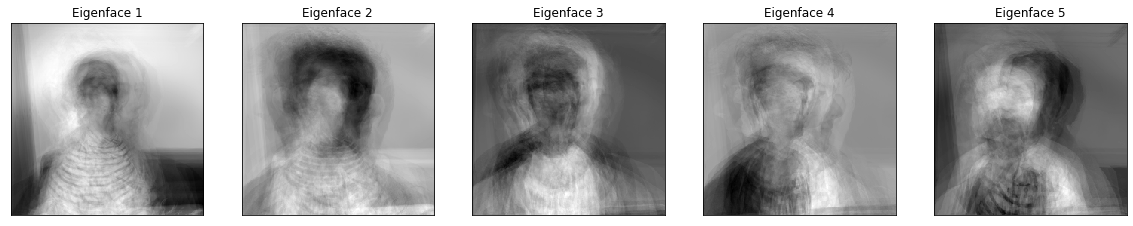

The recognition rate using 8 eigenfaces is 0.9466666666666667.


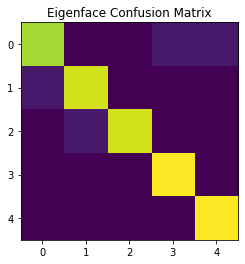

In [45]:
# experimented with a various number of principal components (8 components gave the best recognition rate)
pca_components = 8

# convert (face area of) images to greyscale
# TODO convert only the face area instead of entire image (need a standard head size for that)
X_trn = np.empty((75, 256 * 256))
X_tst = np.empty((75, 256 * 256))
for index, (trnHead, tstHead) in enumerate(zip(trainHeadshots, testHeadshots)):
    X_trn[index] = cv2.cvtColor(trnHead, cv2.COLOR_RGB2GRAY).flatten()
    X_tst[index] = cv2.cvtColor(tstHead, cv2.COLOR_RGB2GRAY).flatten()
X_trn = np.asarray(X_trn)
X_tst = np.asarray(X_tst)

# train PCA
pca = PCA(n_components=pca_components, whiten=True).fit(X_trn)

# display first 5 eigenfaces
plt.figure(figsize=(20,5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.xticks([]), plt.yticks([])
    plt.title("Eigenface {}".format(i + 1))
    plt.imshow(pca.components_[i].reshape((256, 256)), cmap="gray")
plt.show()

# find eigen representations of the images by projecting them onto the computed eigenfaces
X_train_pca = pca.transform(X_trn)
X_test_pca = pca.transform(X_tst)

# find the nearest eigen representation from the training dataset
eigen_predictions = [np.argmin([np.linalg.norm(testPCA - trnPCA) for trnPCA in X_train_pca]) // 15 for testPCA in X_test_pca]
recognitionRateEigen = accuracy_score(labels, eigen_predictions)

print('The recognition rate using {} eigenfaces is {}.'.format(pca_components, recognitionRateEigen))

plt.imshow(confusion_matrix(labels, eigen_predictions))
plt.title('Eigenface Confusion Matrix')
plt.show()

## 6 - Face Tagging

In [ ]:
# TODO

## Experimental Area (TODO remove later)

In [ ]:
img = trainHeadshots[0]

hist_color = []
for i in range(0, img.shape[2]):
    hist_color.append(cv2.calcHist([img], [i], None, [256], [0,256]))
    
print("Image pixel count = " + str(img.shape[0]*img.shape[1]))
print("hist_color[R] pixel count = " + str(sum(hist_color[0])))
print("hist_color[G] pixel count = " + str(sum(hist_color[1])))
print("hist_color[B] pixel count = " + str(sum(hist_color[2])))

# display histograms
plt.figure(figsize=(15,5))
colors = ['r', 'g', 'b']
for i in range(0, img.shape[2]):
    plt.plot(hist_color[i], color=colors[i])
plt.title("RGB Histogram"), plt.xlim([0,256]), plt.ylim(0)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')     
plt.show()